# Домашняя работа 10. Прогнозирование методом auto-arima

Лазарев Эдуард Артемович
N33471

In [1]:
import numpy as np
import pandas as pd

!pip install pmdarima
import pmdarima as pm

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Загружаем данные
df = pd.read_csv('wine_Austral2.dat', sep='\t', header=0, usecols=["red"])
len(df)

174

Проверяем правильность данных

In [3]:
df

,red
0,464
1,675
2,703
3,887
4,1139
...,...
169,1728
170,2201
171,2455
172,2204


In [4]:
df.dtypes

red    int64
dtype: object

Выбираем только один столбец с красным вином

<Figure size 864x576 with 0 Axes>

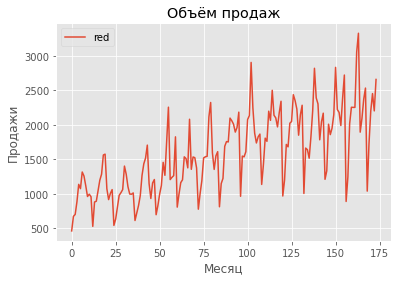

In [5]:
#Построим графики и определим,тип тренда (линейный или нет) и тип сезонности ( аддитивный или мультипликативный)
#  Активируем библиотеки, необходимые для работы
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
#  Указываем размер картинки
plt.figure(figsize=(12, 8))
df.plot()
plt.xlabel(u'Месяц')
plt.ylabel(u'Продажи')
plt.title(u'Объём продаж')
plt.show()

По этому графику можно определить, что тренд линейный, а сезонность мультипликативная. Можно проверить сезонность, взяв логарифм от функции. Если сезонные отклонения будут одинаковыми, то это докажет мультипликативность.

<Figure size 1296x576 with 0 Axes>

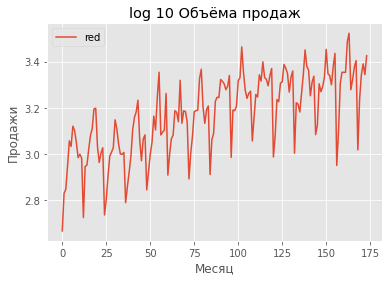

In [6]:
plt.figure(figsize=(18, 8))
np.log10(df).plot()
plt.xlabel(u'Месяц')
plt.ylabel(u'Продажи')
plt.title(u'log 10 Объёма продаж')
plt.show()

Ряд не меняет своего характера, выбросов и пропусков не наблюдается.

In [7]:
# Активируем библиотеку, которую будем использовать
#на сколько месяцев прогнозируем + тип сезонности
horizon_ = 8
season_type = 'multiplicative'
#период сезонных отклонений
seas_period_ = 12

In [8]:
#Если сезонность мультипликативная, надо переходить к логарифмам.
# Получить прогноз для логарифмов, затем вернуться к исходным значениям.
test = df['red'][-horizon_:]
train = df['red'][:-horizon_]
train_log = np.log10(train)
test_log = np.log10(test)
dflog = np.log10(df['red'])

In [9]:
# Задаем параметры процедуры SARIMA
arima = pm.auto_arima(train_log, m=seas_period_, seasonal=True, n_jobs=-1, random_state=239)

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


In [10]:
# Основные характеристики модели
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  166
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 243.687
Date:                                 Mon, 14 Jun 2021   AIC                           -471.374
Time:                                         20:24:21   BIC                           -446.526
Sample:                                              0   HQIC                          -461.287
                                                 - 166                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.75e-05   9.24e-05      0.298      0.766      -0.000       0.000
ar.L1          0.1593      0.092      1.735      0.083      -0.021       0.339
ma.L1         -0.8871      0.053    -16.663      0.000      -0.991      -0.783
ar.S.L12       0.2593      2.114      0.123      0.902      -3.883       4.402
ar.S.L24       0.7229      2.095      0.345      0.730      -3.382       4.828
ma.S.L12      -0.0407      2.129     -0.019      0.985      -4.213       4.131
ma.S.L24      -0.5334      1.638     -0.326      0.745      -3.745       2.678
sigma2         0.0026      0.000      8.548      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.41
Prob(Q):                              0.84   Prob(JB):                         0.49
Heteroskedasticity (H):               1.20   Skew:                            -0.14
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
#   Значения прогноза для логарифмов 
forecast = arima.predict(n_periods=horizon_)
forecast

array([3.37000285, 3.40152946, 3.07341573, 3.19083094, 3.30513327,
       3.31921954, 3.36570085, 3.38340686])

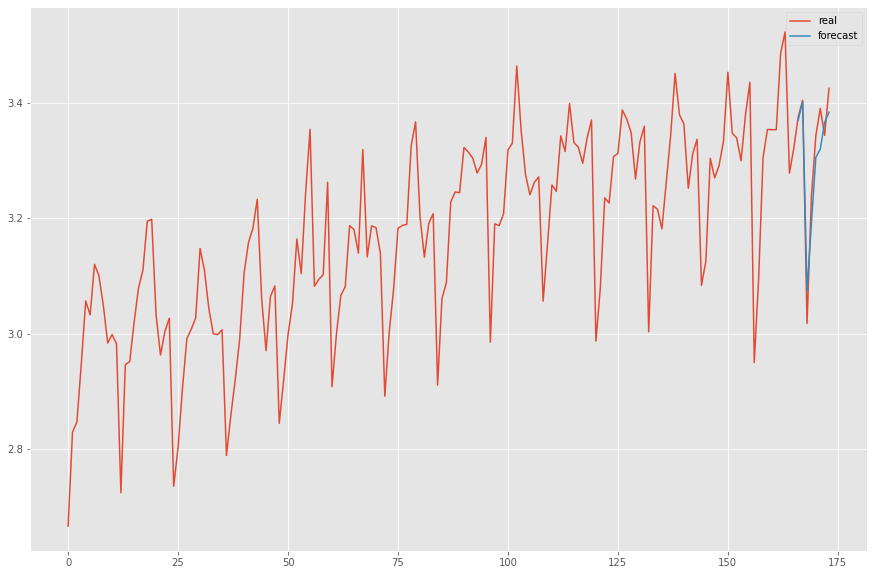

In [12]:
#   Проверяем качество прогноза для логарифмов
#   Строим графики
valid = np.arange(len(train), len(df), 1) # промежуток месяцев, для которых делается прогноз
forecast = pd.DataFrame(forecast, index=valid, columns=['forecast'])
plt.figure(figsize=(15, 10))
plt.plot(dflog, label='real')
plt.plot(forecast, label='forecast')
plt.legend()
plt.show()

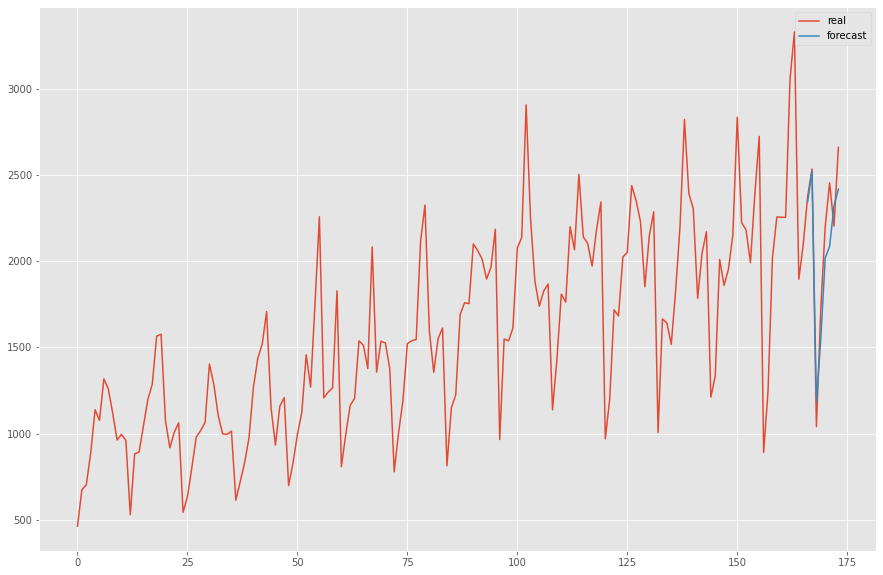

In [13]:
# Переходим к начальным данным, убираем логарифм
valid = np.arange(len(train), len(df), 1)
forecast = pd.DataFrame(10 ** forecast, index=valid, columns=['forecast'])
plt.figure(figsize=(15, 10))
plt.plot(df['red'], label='real')
plt.plot(forecast, label='forecast')
plt.legend()
plt.show()

In [14]:
# Оценим качество модели с использованием параметра Mean Absolute Percentage Error
# Используется неидеальная формула.
# Если значения временного ряда могут равняться нулю, формулу надо будет менять

MAPE_ARIMA = np.mean(np.abs((forecast['forecast'].to_numpy() - test.to_numpy())/ test.to_numpy()))*100
print("MAPE для ARIMA = ", MAPE_ARIMA)

MAPE для ARIMA =  7.938559826956581


## Вывод

По результатам работы было проведено прогнозирование методом auto-arima на 8 месяцев. Обучена модель и построен график с исходным рядом и прогнозом, по которому можно сделать вывод, что результат весьма точен. Тот же вывод можно сделать, глядя на значение параметра MAPE.